# Ebene Geometrie und Gitterpolygone

Heute wollen wir Dreiecke auf einem Gitter mit ganzzahligen Koordinaten und gegebenem Flächeninhalt zählen.

![Geobrett](https://upload.wikimedia.org/wikipedia/commons/9/99/Quadrate_auf_dem_Geobrett_Schr%C3%A4gsicht.jpg)

Dies ist eine gute Gelegenheit, Klassen mit überladenen arithmetischen Funktionen und einem eigenen Gleichheitsbegriff kennen zu lernrn.

In [1]:
class Vector(tuple):
    """Beschreibt einen Vektor in der zweidimensionalen
    euklidischen Ebene"""
    
    def __new__(cls, *coords): 
        if len(coords) != 2: 
            raise ValueError(f"Dimension must be 2: {coords}")
        return super().__new__(cls, coords)
        
    def __add__(self, q):
        return Vector(self[0] + q[0], self[1] + q[1])
    
    def __sub__(self, q):
        return Vector(self[0] - q[0], self[1] - q[1])
    
    def __mul__(self, q):
        """Berechne das Skalarprodukt"""
        return self[0] * q[0] + self[1] * q[1]
    
    def normal(self):
        """Berechne den Normalenvektor"""
        return Vector(self[1], -self[0])    
    
    def len2(self):
        """Berechne das Quadrat der Länge des Vektors"""
        return self[0]*self[0] + self[1]*self[1]

In [2]:
class GeoBoard(tuple):
    """Beschreibt ein GeoBoard mit n*n Punkten.
    """
    
    def __new__(cls, n):
        points = [ Vector(x, y) for x in range(n) for y in range(n) ]
        return super().__new__(cls, points)
    
    def __init__(self, n):
        self.size = n
    
    def __repr__(self):
        return f"GeoBoard({self.size}): {super().__repr__()}"

GeoBoard(4)

GeoBoard(4): ((0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3))

In [3]:
from collections import defaultdict

class Triangle(tuple):
    """Beschreibt Dreiecke in der Ebene."""
    
    def _ensure_vector_(p):
        if isinstance(p, Vector): 
            return p 
        elif isinstance(p[0], tuple):
            return [ Triangle._ensure_vector_(q) for q in p[0]]
        else: 
            return Vector(*p)
    
    def __new__(cls, *points):
        """Erzeuge ein Dreieck aus den übergebenen Punkten.
        
        Die Punkte werden ggf. "positiv orientiert", damit wir 
        einfacher bestimmen können, ob ein Punkt im Inneren des
        Dreiecks liegt.
        """
        points = list(map(Triangle._ensure_vector_, points))
        
        # Check we have three points
        if len(points) != 3 or len(set(points)) != 3: 
            raise ValueError("Three different points needed to create a triangle")
        
        # Check that the points are not colinear and in positive order
        dot = (points[1] - points[0]).normal() * (points[2] - points[1])
        if dot == 0:
            raise ValueError(f"These points are on a line: {points}")
        elif dot < 0:
            # The points are in wrong order and need to be reversed
            points = reversed(points)
        
        return super().__new__(cls, points)
    
    def __init__(self, *points):
        """Initialisiere das Dreieck.
        
        Berechne die Seitenlängen.
        """        
        sides = defaultdict(int)
        normals = []
        for i in range(3):
            j = (i + 1) % 3
            sides[(self[j] - self[i]).len2()] += 1
            normals.append(((self[j] - self[i]).normal(), self[i]))
        
        self.sides = tuple(sorted(sides.items()))
        self.normals = tuple(normals)
        self.N = max(max([x for (x, y) in self]), max([y for (x, y) in self])) + 1
        
    def __repr__(self):
        return f"Triangle(sides: {self.sides}, points: {super().__repr__()}, max: {self.N})"
    
    def __hash__(self):
        return hash(self.sides)
    
    def __eq__(self, other):
        """Check if the other triangle is equal (congruent) 
        to this one.
        
        According to elementary geometry, this is the case iff
        the length of the three sides are identical.
        """
        return self.sides == other.sides
    
    def is_boundary(self, p):
        """Check if p is on the boundary of the triangle.
        
        This is the case, if there is a side rs with rp and rs being colinear
        and (p - r) * (p - s) <= 0."""
        for i in range(3):
            #print(f"{p} {self[i]} {i}")
            if p == self[i]:
                return True
            
            j = (i + 1) % 3
            if (p - self[i]) * (self[j] - self[i]).normal() != 0:
                continue
            else:
                return (p - self[i]) * (p - self[j]) <= 0
            
        return False
    
    def is_inner(self, p):
        """Check if p is an inner or boundary point.
        
        These points have a positive dot product with all normals.
        """
        for (n, q) in self.normals:
            #print(f"{p}: {n*(p-q)}")
            if n * (p-q) < 0:
                return False
    
        return True
 
    def area(self):
        """Calculate the area using Pick's theorem."""
        inner = []
        boundary = []
        for p in (Vector(x, y) for x in range(self.N) for y in range(self.N)):
            if self.is_boundary(p):
                boundary.append(p)
                
            elif self.is_inner(p):
                inner.append(p)
    
        return len(inner) + len(boundary)/2 - 1
    

In [4]:
t1 = Triangle((0, 1), (1, 2), (0, 3))
t1.area()

1.0

In [5]:
t1

Triangle(sides: ((2, 2), (4, 1)), points: ((0, 3), (1, 2), (0, 1)), max: 4)

In [176]:
from itertools import product
gb = GeoBoard(4)
triangles = defaultdict(set)

for points in product(*[iter(gb) for i in range(3)]):
    try: 
        tr = Triangle(*points)
        triangles[tr.area()].add(tr)
    except Exception:
        pass
    
for k in sorted(triangles.keys()):
    print(f"Anzahl Dreiecke mit Fläche {k}: {len(triangles[k])}")

Anzahl Dreiecke mit Fläche 0.5: 4
Anzahl Dreiecke mit Fläche 1.0: 5
Anzahl Dreiecke mit Fläche 1.5: 6
Anzahl Dreiecke mit Fläche 2.0: 4
Anzahl Dreiecke mit Fläche 2.5: 2
Anzahl Dreiecke mit Fläche 3.0: 4
Anzahl Dreiecke mit Fläche 3.5: 1
Anzahl Dreiecke mit Fläche 4.0: 1
Anzahl Dreiecke mit Fläche 4.5: 2


Triangle(sides: ((1, 1), (2, 1), (5, 1)), points: ((0, 0), (0, 1), (1, 2)), max: 3)


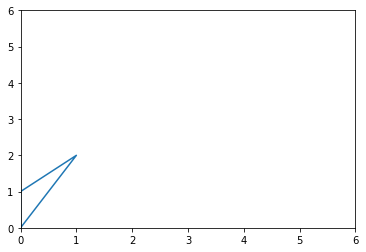

Triangle(sides: ((1, 2), (2, 1)), points: ((0, 0), (0, 1), (1, 0)), max: 2)


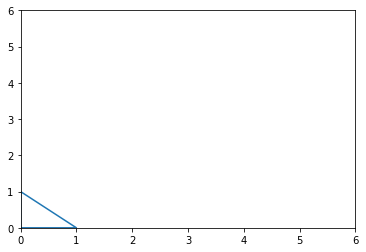

Triangle(sides: ((2, 1), (5, 1), (13, 1)), points: ((2, 3), (1, 1), (0, 0)), max: 4)


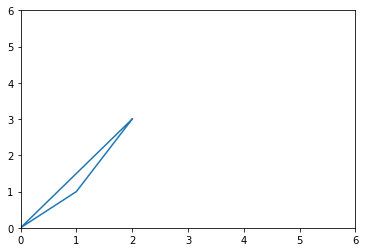

Triangle(sides: ((1, 1), (5, 1), (10, 1)), points: ((0, 0), (0, 1), (1, 3)), max: 4)


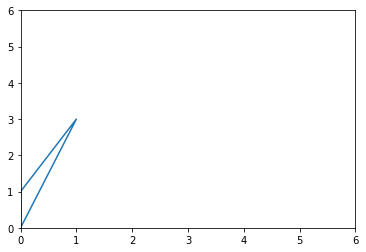

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt

for tr in list(triangles[0.5]):
    x = []
    y = []
    for i in range(4):
        i = i % 3
        x.append(tr[i][0])
        y.append(tr[i][1])
        
    print(f"{tr}")
    plt.plot(x, y)
    plt.axis([0, 6, 0, 6])

    plt.show()    